<a href="https://colab.research.google.com/github/monish-08-code/cyber/blob/main/projectdata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix
from sklearn.cluster import KMeans
import tensorflow as tf
import seaborn as sns

from google.colab import files
data=files.upload()

Saving Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv to Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv


/tmp/ipython-input-634833209.py:32: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1744/1744 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
Accuracy: 0.9991753020904299
Precision: 0.9989114546076572
Recall: 0.9996576301783435
F1 Score: 0.9992844030988457
ROC-AUC: 0.9999980061033532


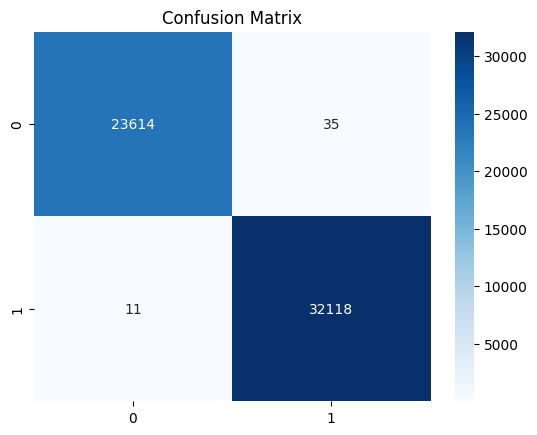

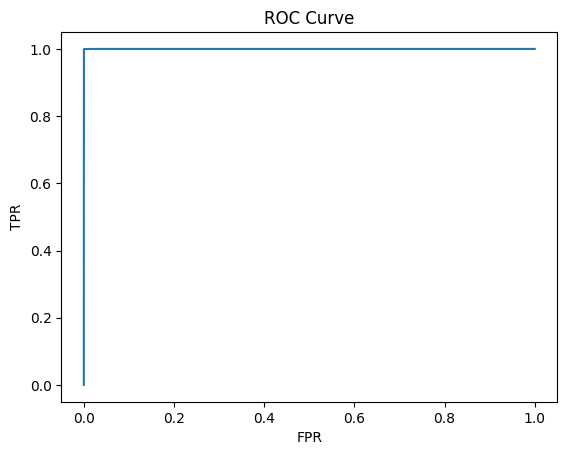

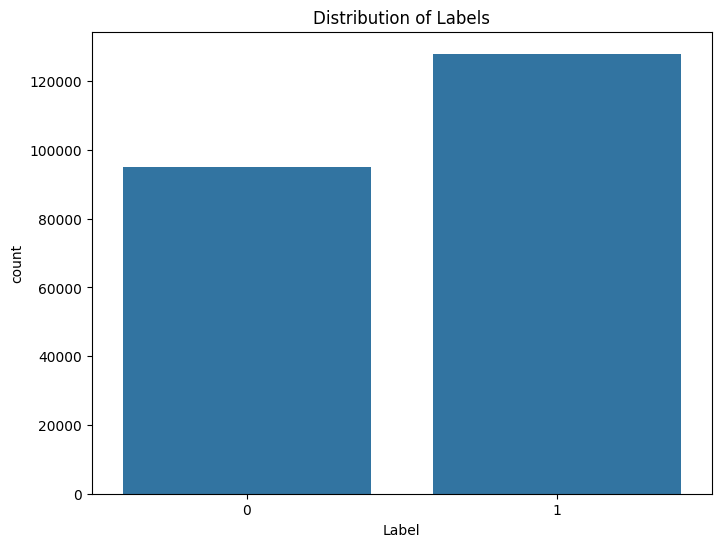

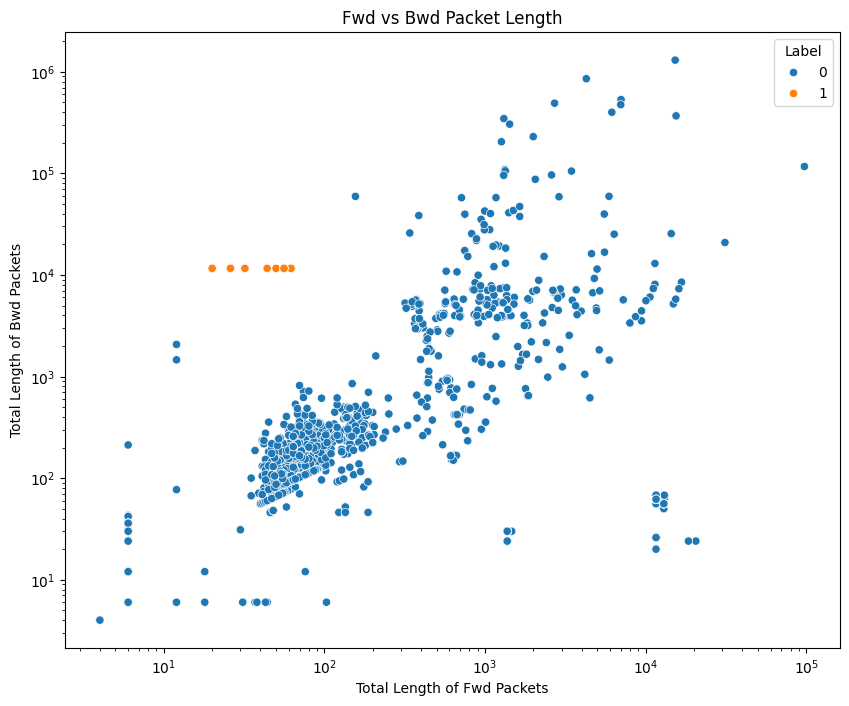

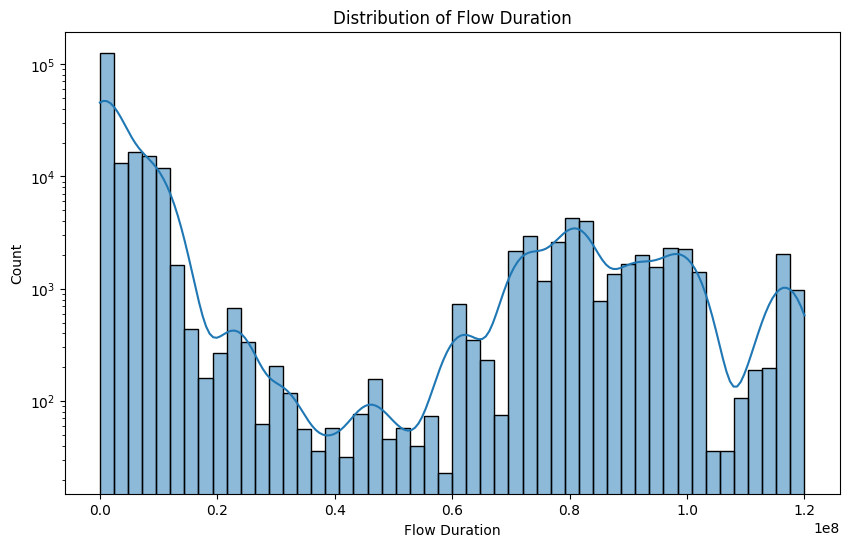

In [5]:
import io

# Assuming data is available from the previous cell's upload
# Read the header from the uploaded CSV to get column names
csv_content = data['Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv'].decode('utf-8')
first_line = csv_content.split('\n')[0]
raw_column_names = [col.strip() for col in first_line.split(',')]

# Handle duplicate column names by appending a suffix
column_names = []
name_counts = {}
for name in raw_column_names:
    current_name = name
    if current_name in name_counts:
        name_counts[current_name] += 1
        name_to_add = f"{current_name}_{name_counts[current_name]}"
    else:
        name_counts[current_name] = 0
        name_to_add = current_name
    column_names.append(name_to_add)

df = pd.read_csv(io.StringIO(csv_content), names=column_names, skiprows=1)
df = df.drop_duplicates()

# -------------------------------
# Convert numeric columns
# -------------------------------
for col in df.columns:
    if col != 'Label':
        df[col] = pd.to_numeric(df[col], errors='coerce')
        # Replace infinite values with NaN so they can be filled with the median
        df[col].replace([np.inf, -np.inf], np.nan, inplace=True)

# Fill numeric NaN with median
for col in df.columns:
    if col != 'Label' and df[col].isnull().any():
        df[col] = df[col].fillna(df[col].median())

# -------------------------------
# Encode label (Normal = 0, Attack = 1)
# -------------------------------
df['Label'] = df['Label'].apply(lambda x: 0 if x.lower() == "benign" or x.lower() == "normal" else 1)

# -------------------------------
# Select features / target
# -------------------------------
X = df.drop("Label", axis=1)
y = df["Label"]

# -------------------------------
# Scale numeric features
# -------------------------------
sc = StandardScaler()
X = sc.fit_transform(X)

# -------------------------------
# Split data
# -------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# -------------------------------
# Build Neural Network
# -------------------------------
model = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=0)

model.save("tf_model.keras")

# -------------------------------
# Predictions
# -------------------------------
y_prob = model.predict(X_test).ravel()
y_pred = (y_prob > 0.5).astype(int)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))

# -------------------------------
# Confusion Matrix
# -------------------------------
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

# -------------------------------
# ROC Curve
# -------------------------------
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr)
plt.title("ROC Curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.show()

# -------------------------------
# Clustering
# -------------------------------
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X)

# -------------------------------
# Visualization
# -------------------------------
plt.figure(figsize=(8, 6))
sns.countplot(x=df['Label'])
plt.title('Distribution of Labels')
plt.show()

plt.figure(figsize=(10, 8))
sampled_df = df.sample(n=5000, random_state=42)
sns.scatterplot(
    x=sampled_df['Total Length of Fwd Packets'],
    y=sampled_df['Total Length of Bwd Packets'],
    hue=sampled_df['Label']
)
plt.xscale('log')
plt.yscale('log')
plt.title('Fwd vs Bwd Packet Length')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['Flow Duration'], bins=50, kde=True)
plt.yscale('log')
plt.title("Distribution of Flow Duration")
plt.show()